In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Input, Dropout, LayerNormalization

In [ ]:
device = 'cpu'

In [ ]:
df = pd.read_csv('/content/english-spanish-dataset.csv')
df=df[['english' , 'spanish']]
df.columns = ['en','sp']
len(df)

120614

In [ ]:
# Take a random sample of 40,000 entries
df = df.sample(n=40000, random_state=69)
df

,en,sp
5744,dont say that,no digas eso
41815,my aunt gave me a camera,mi tia me regalo una camara
116057,compare the two carefully and you will see the...,compara ambos atentamente y veras la diferencia
84561,pass me the salt and pepper please,pasadme la sal y la pimienta por favor
78355,she fled for fear of being caught,ella huyo por miedo a que la cogieran
...,...,...
113144,tom asked mary how many people had come to her...,tom le pregunto a mary cuantas personas habian...
104469,tom abandoned the idea of buying a new truck,tom abandono la idea de comprar un nuevo camion
44269,dont you want to kiss me,no queres besarme
77136,i cant see who tom is talking to,no puedo ver con quien habla tom


In [ ]:
df['en'] = df['en'].str.lower()
df['sp'] = df['sp'].str.lower()

In [ ]:
en_text = df['en'].values
sp_text = df['sp'].values

In [ ]:
for i in range(en_text.shape[0]):
    en_text[i] = "sos " + str(en_text[i]) + " eos"
    sp_text[i] = "sos " + str(sp_text[i]) + " eos"

In [ ]:
num_words = 10000
tokenizer_en = Tokenizer(num_words = num_words , filters = ' !"#$%&()*+,-./:;<=>?@[\\]^_`{|}~')
tokenizer_en.fit_on_texts(en_text)
en_sentences = tokenizer_en.texts_to_sequences(en_text)

In [ ]:
word_index_en = tokenizer_en.word_index
print( f" Number of words in english is: {len(word_index_en)} ")

 Number of words in english is: 9012 


In [ ]:
tokenizer_sp = Tokenizer(num_words = num_words , filters = ' !"#$%&()*+,-./:;<=>?@[\\]^_`{|}~')
tokenizer_sp.fit_on_texts(sp_text)
sp_sentences = tokenizer_sp.texts_to_sequences(sp_text)

In [ ]:
word_index_sp = tokenizer_sp.word_index
print( f" Number of words in spanish is: {len(word_index_sp)} ")

 Number of words in spanish is: 15329 


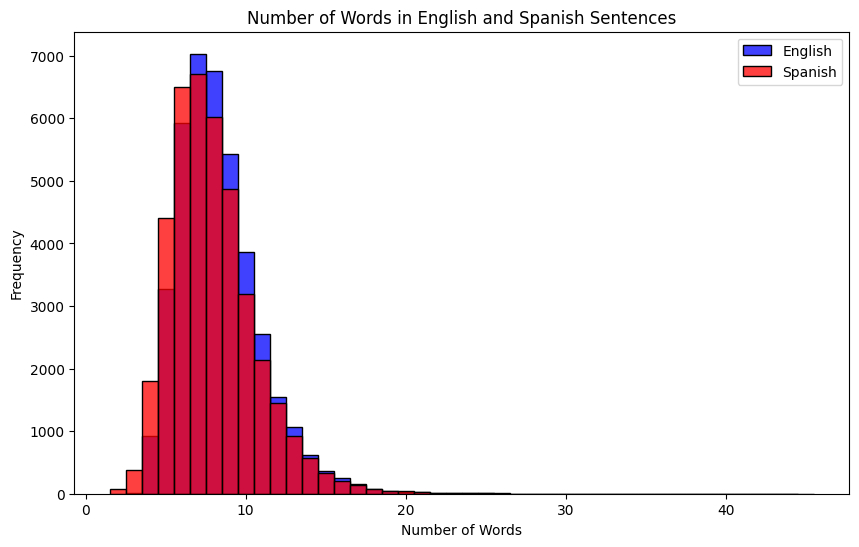

In [ ]:
# Calculate the length of each sequence
en_lengths = [len(seq) for seq in en_sentences]
sp_lengths = [len(seq) for seq in sp_sentences]

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(en_lengths, bins=range(1, max(en_lengths)+2), color='blue', kde=False, label='English', discrete=True)
sns.histplot(sp_lengths, bins=range(1, max(sp_lengths)+2), color='red', kde=False, label='Spanish', discrete=True)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Number of Words in English and Spanish Sentences')
plt.legend()
plt.show()

In [ ]:
maxlen_en = max(len(seq) for seq in en_sentences)
maxlen_sp = max(len(seq) for seq in sp_sentences)
maxlen = max(maxlen_en, maxlen_sp)
print(maxlen)

45


In [ ]:
en_sentences = pad_sequences(en_sentences , maxlen = 25, padding = 'post' , truncating='post')
sp_sentences = pad_sequences(sp_sentences , maxlen = 25, padding = 'post' , truncating='post')

In [ ]:
def get_angles(pos , i , embedding_dim):
    '''
    Function to comput the angles for positional encoding

    Returns the angle computed
    '''
    angle_rates = 1/ np.power(10000 , (2*(i//2)) / np.float32(embedding_dim))

    return pos * angle_rates

In [ ]:
def positional_encoding(pos , embedding_dim):
    '''
    Adds positional encoding to the embeddings to be fed to the Transformer model.

    Computes sin and cos of the angles determined by the get_angles()
    and adds the value to an axis of embeddings

    '''
    angle_radians = get_angles(np.arange(pos)[:, np.newaxis],
                              np.arange(embedding_dim)[np.newaxis, :] ,
                              embedding_dim)

    angle_radians[: , 0::2] = np.sin( angle_radians[: , 0::2])

    angle_radians[: , 1::2] = np.cos(angle_radians[: , 1::2])

    pos_encoding = angle_radians[np.newaxis, ...]
    return tf.cast(pos_encoding , dtype = tf.float32)

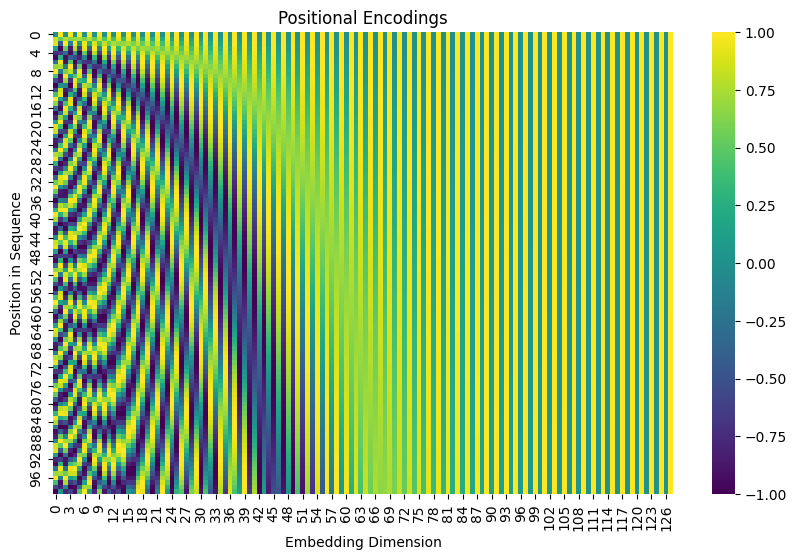

In [ ]:
pos_encoding = positional_encoding(200,256)

plt.figure(figsize=(14,8))
sns.heatmap(pos_encoding[0] , cmap='viridis')
plt.xlabel("Embedding Dimension")
plt.ylabel("Position in Sequence")
plt.title('Positional Encodings')
plt.show()

In [ ]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size , size)) , -1 , 0)
    return mask

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq,0) , tf.float32)

    return seq[:, tf.newaxis , tf.newaxis, : ]

In [ ]:
def create_masks(input , target):
    enc_pad_mask = create_padding_mask(input)
    dec_pad_mask = create_padding_mask(input)
    look_ahead_mask = create_look_ahead_mask(tf.shape(target)[1])
    dec_target_pad_mask = create_padding_mask(target)
    combine_mask = tf.maximum(dec_target_pad_mask , look_ahead_mask)

    return enc_pad_mask , combine_mask , dec_pad_mask

In [ ]:
def scaled_dot_product(q, k, v, mask):
    matrix_mul_q_k = tf.matmul(q,k,transpose_b= True)

    dk = tf.cast(tf.shape(k)[-1], dtype = tf.float32)

    scaled_dk = tf.math.sqrt(dk)
    scaled_attention_logits = matrix_mul_q_k/scaled_dk

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits , axis = -1)
    output = tf.matmul(attention_weights, v)

    return output , attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, key_dim, num_heads, dropout_rate = 0.0):
        '''
        Multi head attention layer

        Args :
        key_dim : The dimension of the key vectors.
        num_heads : The number of attention heads
        drouout_rates
        '''

        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim

        assert key_dim % num_heads == 0
        self.depth = self.key_dim // self.num_heads

        self.wq = Dense(key_dim)
        self.wk = Dense(key_dim)
        self.wv = Dense(key_dim)

        self.dropout = Dropout(dropout_rate)
        self.dense = Dense(key_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm =[0,2,1,3])

    def call(self , v, k, q, mask = None):
        '''
        Forward pass through multi head attention layer

        Return:
        tf.Tensor: the ouitput tensor
        tf.Tensor: the attention weights
        '''
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm =[0,2,1,3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.key_dim))
        output = self.dense(concat_attention)
        output = self.dropout(output)

        return output, attention_weights

In [ ]:
def FeedForward(embedding_dim, fully_connected_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),
        tf.keras.layers.Dense(embedding_dim)
    ])

    return model

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate = 0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)

        self.layernorm1 = LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = LayerNormalization(epsilon = 1e-6)

        self.dropout = Dropout(dropout_rate)

        self.ffn = FeedForward(embedding_dim , fully_connected_dim)


    def call(self, x, training, mask):
        '''
        Forward pass throught the encoder layer

        Returns:
         tf. Tensor: The output tensor after passing through the encoder layer.
        '''

        att_output , _ = self.mha(x, x, x, mask)

        out1 = self.layernorm1(att_output + x)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output, training = training)

        output = self.layernorm2(ffn_output + out1)

        return output


In [ ]:
class Encoder( tf.keras.layers.Layer):
    def __init__(self,
                 num_layers,
                 embedding_dim,
                 num_heads,
                 fully_connected_dim,
                 input_vocab_size,
                 maximum_position_encoding,
                 dropout_rates = 0.1):
        super(Encoder, self).__init__()

        self.num_layers = num_layers
        self.embedding_dim = embedding_dim

        self.embedding = Embedding(input_vocab_size, embedding_dim)

        self.pos_encoding = positional_encoding(maximum_position_encoding, embedding_dim)

        self.enc_layers = [EncoderLayer(embedding_dim, num_heads, fully_connected_dim, dropout_rates) for _ in range(num_layers)]

        self.dropout = Dropout(dropout_rates)

    def call(self, inputs, training, mask):
        '''
        Forward pass through encoder

        Return:
        tf.tensor: The encoded sequence tensor.

        '''

        seq_len = tf.shape(inputs)[1]

        inputs = self.embedding(inputs)

        inputs *= tf.math.sqrt(tf.cast(self.embedding_dim , tf.float32))

        inputs +=self.pos_encoding[:, :seq_len, :]

        inputs = self.dropout(inputs, training = training)

        for i in range(self.num_layers):
            inputs = self.enc_layers[i](inputs, training = training , mask = mask)

        return inputs

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate = 0.1):

        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)
        self.mha2 = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)

        self.ffn = FeedForward(embedding_dim , fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = LayerNormalization(epsilon = 1e-6)
        self.layernorm3 = LayerNormalization(epsilon = 1e-6)


        self.dropout3 = Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        '''
        Forward pass throught the decoder layer

        Returns:
         tf. Tensor: The output tensor after passing through the decoder layer.
        '''

        attn1 , attn_weights1  = self.mha1(x, x, x, look_ahead_mask)

        out1 = self.layernorm1(attn1 + x)

        attn2 , attn_weights2  = self.mha2(enc_output, enc_output, out1, padding_mask)

        out2 = self.layernorm2(attn2 + out1)


        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training = training)

        output = self.layernorm3(ffn_output + out2)

        return output, attn_weights1, attn_weights2

In [ ]:
class Decoder( tf.keras.layers.Layer):
    def __init__(self,
                 num_layers,
                 embedding_dim,
                 num_heads,
                 fully_connected_dim,
                 target_vocab_size,
                 maximum_position_encoding,
                 dropout_rates = 0.1):
        super(Decoder, self).__init__()

        self.num_layers = num_layers
        self.embedding_dim = embedding_dim

        self.embedding = Embedding(target_vocab_size, embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, embedding_dim)
        self.dec_layers = [DecoderLayer(embedding_dim, num_heads, fully_connected_dim, dropout_rates) for _ in range(num_layers)]
        self.dropout = Dropout(dropout_rates)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        '''
        Forward pass through Decoder

        Return:
        tf.tensor: The decoded sequence tensor.
        dict: Dictionary containing attention weights for each decoder layer
        '''

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)

        x *= tf.math.sqrt(tf.cast(self.embedding_dim , tf.float32))

        x +=self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training = training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training = training , look_ahead_mask = look_ahead_mask, padding_mask = padding_mask)

            attention_weights[f"decoder_layer{i + 1}_ block1"] = block1
            attention_weights[f"decoder_layer{i + 1}_ block2"] = block2


        return x, attention_weights

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, embedding_dim,
                 num_heads, fully_connected_dim,
                 input_vocab_size, target_vocab_size,
                 max_positional_encoding_input,
                 max_positional_encoding_target,
                 dropout_rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
                               max_positional_encoding_input, dropout_rate)
        self.decoder = Decoder(num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
                               max_positional_encoding_target, dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')

    def call(self, inp, tar, training=None, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None):
        '''
        Forward pass through the transformer

        Returns:
        tf.Tensor: The final prediction tensor
        dict: Dictionary containing attention weights from the decoder
        '''

        enc_output = self.encoder(inp, training=training, mask=enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)


        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [ ]:
embedding_dim = 256
fully_connected_dim = 512
num_layers = 4
num_heads = 8
dropout_rates = 0.1

input_vocab_size = len(tokenizer_sp.word_index) + 2
target_vocab_size = len(tokenizer_en.word_index) + 2

max_positional_encoding_input = input_vocab_size
max_positional_encoding_target = target_vocab_size

EPOCHS = 50
batch_size = 256

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, embedding_dim, warmup_steps = 4000):
        super(CustomSchedule, self).__init__()
        self.embedding_dim = tf.cast(embedding_dim, dtype = tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, dtype = tf.float32)
    def __call__(self, step):
        step = tf.cast(step, dtype= tf.float32)
        arg1 = tf.math.sqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.embedding_dim) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(embedding_dim)

In [ ]:
transformer = Transformer(num_layers, embedding_dim,
                          num_heads, fully_connected_dim,
                          input_vocab_size, target_vocab_size,
                          max_positional_encoding_input, max_positional_encoding_target,
                          dropout_rates)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1 = 0.9,beta_2 = 0.98, epsilon= 1e-9 )

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
def loss_function(true_vals , predictions):
    mask = tf.math.logical_not(tf.math.equal(true_vals, 0))

    loss_ = loss_object(true_vals, predictions)

    mask= tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

def accuracy_function(true_vals, predictions):
    accuracies  = tf.equal(true_vals, tf.argmax(predictions, axis = 2))

    mask = tf.math.logical_not(tf.math.equal(true_vals, 0))

    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype = tf.float32)
    mask = tf.cast(mask, dtype = tf.float32)

    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

In [ ]:
@tf.function()
def train_step(encoder_input, target):
    decoder_input = target[:, :-1]

    expected_output = target[:, 1:]

    enc_padding_mask , combined_mask, dec_padding_mask = create_masks(encoder_input, decoder_input)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(encoder_input, decoder_input, training=True,
                                     enc_padding_mask=enc_padding_mask, look_ahead_mask=combined_mask, dec_padding_mask=dec_padding_mask)

        loss = loss_function(expected_output, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(expected_output, predictions)


In [ ]:
for epoch in range(0 , EPOCHS+1):

    train_loss.reset_state()
    train_accuracy.reset_state()
    current_batch_index = 0


    for i in range(int(len(en_sentences) / batch_size )):
        input_batch = tf.convert_to_tensor(np.array(en_sentences[current_batch_index:current_batch_index + batch_size]),
                                           dtype = tf.int64)
        target_batch = tf.convert_to_tensor(np.array(sp_sentences[current_batch_index:current_batch_index + batch_size]),
                                           dtype = tf.int64)

        current_batch_index += batch_size

        train_step(input_batch, target_batch)

    print(f"Epoch: {epoch}, Loss: {train_loss.result():.4f} , Accuracy: {train_accuracy.result():.4f} ")

Epoch: 0, Loss: nan , Accuracy: 0.6204 
Epoch: 1, Loss: nan , Accuracy: 0.7111 
Epoch: 2, Loss: nan , Accuracy: 0.7111 
Epoch: 3, Loss: nan , Accuracy: 0.7111 
Epoch: 4, Loss: nan , Accuracy: 0.7111 
Epoch: 5, Loss: nan , Accuracy: 0.7111 
Epoch: 6, Loss: nan , Accuracy: 0.7111 
Epoch: 7, Loss: nan , Accuracy: 0.7111 
Epoch: 8, Loss: nan , Accuracy: 0.7111 
Epoch: 9, Loss: nan , Accuracy: 0.7111 
Epoch: 10, Loss: nan , Accuracy: 0.7111 
Epoch: 11, Loss: nan , Accuracy: 0.7111 
Epoch: 12, Loss: nan , Accuracy: 0.7111 
Epoch: 13, Loss: nan , Accuracy: 0.7111 
Epoch: 14, Loss: nan , Accuracy: 0.7111 
Epoch: 15, Loss: nan , Accuracy: 0.7111 
Epoch: 16, Loss: nan , Accuracy: 0.7111 
Epoch: 17, Loss: nan , Accuracy: 0.7111 
Epoch: 18, Loss: nan , Accuracy: 0.7111 
Epoch: 19, Loss: nan , Accuracy: 0.7111 
Epoch: 20, Loss: nan , Accuracy: 0.7111 
Epoch: 21, Loss: nan , Accuracy: 0.7111 
Epoch: 22, Loss: nan , Accuracy: 0.7111 
Epoch: 23, Loss: nan , Accuracy: 0.7111 
Epoch: 24, Loss: nan , Acc

In [ ]:
transformer.save_weights('transformer_weights/model_weights')

In [ ]:
# Compress the weights directory (Optional)
!zip -r model_weights.zip transformer_weights/

# Download the weights file or zip
from google.colab import files

# Download the compressed file
files.download('model_weights.zip')

  adding: transformer_weights/ (stored 0%)
  adding: transformer_weights/model_weights.index (deflated 88%)
  adding: transformer_weights/model_weights.data-00000-of-00001 (deflated 89%)
  adding: transformer_weights/checkpoint (deflated 42%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>